In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import Resize
from sklearn.model_selection import train_test_split
import PIL
import urllib
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

seed = 42
np.random.seed(seed + 1)
torch.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'device: {device}')

device: cuda


In [27]:
def get_mnist_data(path='~/data', as_rgb=False, download=False, transforms=[]):
    reshape = lambda x: x
    if as_rgb:
        reshape = lambda x: x.repeat(3, 1, 1)
    train_data = torchvision.datasets.MNIST(
        path,
        download=download,
        train=True,
        transform=torchvision.transforms.Compose([
            *transforms,
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(reshape),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    )
    test_data = torchvision.datasets.MNIST(
        path,
        download=download,
        train=False,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(reshape),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    )
    
    return train_data, test_data

def get_optimizer(model, optimizer='sgd', lr=0.001, weight_decay=0, momentum=0, betas=(0.9, 0.999), eps=1e-8):
    if optimizer == 'sgd':
        opt = torch.optim.SGD(
            model.parameters(),
            lr=lr, 
            weight_decay=weight_decay, 
            momentum=momentum
        )
    if optimizer == 'adam':
        opt = torch.optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=betas,
            eps=eps
        )
    return opt

def train_model(train_data, model, opt, loss_fn, test_data=None, num_epochs=1000, plot_loss=True, batch_size=32,
               tensorboard=False, print_loss=True, show_batches_bar=False):
    if tensorboard:
        writer = SummaryWriter()
    losses = []
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    if test_data is not None:
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    for epoch in tqdm(range(num_epochs)):
        model = model.train()
        batch_losses = []
        batch_correct = []
        iterator = tqdm(train_loader, leave=False) if show_batches_bar else train_loader
        for X, y in iterator:
            X = X.to(device)
            y = y.to(device)
            opt.zero_grad()
            yhat = model(X)
            loss = loss_fn(yhat, y)
            loss.backward()
            opt.step()
            batch_losses.append(float(loss)* batch_size)
            batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
        train_loss = sum(batch_losses) / len(train_data)
        train_acc = sum(batch_correct) / len(train_data)
        losses.append(train_loss)
        

        if test_data is not None:
            model = model.eval()
            batch_losses = []
            batch_correct = []
            iterator = tqdm(test_loader, leave=False) if show_batches_bar else test_loader
            for X, y in iterator:
                X = X.to(device)
                y = y.to(device)
                opt.zero_grad()
                yhat = model(X)
                loss = loss_fn(yhat, y)
                batch_losses.append(float(loss) * batch_size)
                batch_correct.append(float((yhat.argmax(dim=1) == y).sum().cpu()))
            test_loss = sum(batch_losses) / len(test_data)
            test_acc = sum(batch_correct) / len(test_data)
        else:
            test_loss = -999
            test_acc = -999

        if tensorboard:
            writer.add_scalar("Training Loss", train_loss, epoch+1)
            writer.add_scalar("Training Accuracy", train_acc, epoch+1)
            writer.add_scalar("Test Loss", test_loss, epoch+1)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)
        if print_loss:
            s1 = f'epoch: {epoch+1: <3}   ' 
            s2 = f'train loss: {round(train_loss, 4): <6}   train acc: {round(train_acc, 4): <6}   ' 
            s3 = f'test loss: {round(test_loss, 4): <6}   test acc: {round(test_acc, 4): <6}'
            print(s1 + s2 + s3)
    if plot_loss:
        plt.plot(range(len(losses)), losses)
    if tensorboard:
        writer.flush()
        writer.close()
    return model

def get_n_params(model):
    params = list(model.parameters())
    shapes = [param.detach().numpy().shape for param in params]
    n_params = sum([np.prod(shape) for shape in shapes])
    return n_params

def eval_model(model, X_train, y_train, X_test, y_test):
    model = model.eval().to('cpu')
    y_pred_train = model(X_train).argmax(dim=1)
    y_pred_test = model(X_test).argmax(dim=1)
    print(f'train accuracy: {(y_pred_train == y_train).sum() / len(y_train)}')
    print(f'test accuracy: {(y_pred_test == y_test).sum() / len(y_test)}')

In [28]:
train_data, test_data = get_mnist_data(path='~/data', as_rgb=True, download=False)

In [29]:
train_data.data.shape, train_data.targets.shape, test_data.data.shape, test_data.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [30]:
X_train = torch.stack([x for x,y in train_data]).float()
y_train = torch.tensor([y for x,y in train_data]).float()
X_test = torch.stack([x for x,y in test_data]).float()
y_test = torch.tensor([y for x,y in test_data]).float()

# Cuda

In [31]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True)

x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([32, 3, 28, 28]), torch.Size([32]))

In [32]:
x.get_device(), y.get_device() # -1 = cpu, 0 = gpu

(-1, -1)

In [33]:
x = x.to(device)
y = y.to(device)

x.get_device(), y.get_device()

(0, 0)

# Transfer Learning

Idea: Large pretrained models trained on lots of data have learned how to extract visual features really well. Take that pretrained model, add a new output layer, and just finetune that new layer on your new data. In a sense, transfer learning gives you a better initialization than starting randomly.

Steps: Given some labeled data and a pretrained model trained on a much bigger dataset,
- Remove the original output layer from that model
- Add one or more new, initialized output layers that matches your number of classes
- Keeping the earlier layers in the pretrained model fixed, finetune just that last layer on your data
- If desired, unfreeze the earlier pretrained layers and finetune those as well

Tip: If just finetuning the last layer, pre-extract the features from the frozen pretrained network to save on computation.

In [39]:
# way too slow on CPU
# freeze all but last 3 layer groups, and replace last fc layer with new random layer

model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
for layer in [model.layer3, model.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

last_layer = model.fc
in_features = last_layer.in_features
out_features = len(test_data.targets.unique())
model.fc = nn.Linear(in_features, out_features)

model = model.to(device)

  0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1               train loss: 0.1234   train acc: 0.9639               test loss: 0.068   test acc: 0.9816
epoch: 2               train loss: 0.0538   train acc: 0.9838               test loss: 0.0484   test acc: 0.9846
epoch: 3               train loss: 0.0415   train acc: 0.9873               test loss: 0.0415   test acc: 0.9885
epoch: 4               train loss: 0.0332   train acc: 0.9903               test loss: 0.0424   test acc: 0.9881
epoch: 5               train loss: 0.0268   train acc: 0.9921               test loss: 0.0395   test acc: 0.9888
epoch: 6               train loss: 0.0263   train acc: 0.9921               test loss: 0.0374   test acc: 0.9887
epoch: 7               train loss: 0.0228   train acc: 0.993               test loss: 0.0364   test acc: 0.9897
epoch: 8               train loss: 0.0186   train acc: 0.9942               test loss: 0.0411   test acc: 0.9892
epoch: 9               train loss: 0.0178   train acc: 0.9948               test loss: 0.0367   te

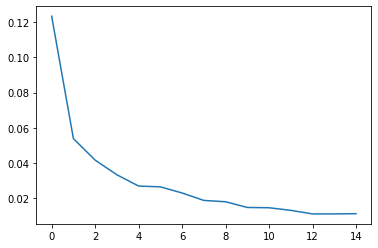

In [40]:
loss_fn = nn.CrossEntropyLoss()
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=0.)
model = train_model(train_data, model, opt, loss_fn, test_data=test_data, num_epochs=15, batch_size=128)

In [88]:
eval_model(model, X_train, y_train, X_test, y_test)

train accuracy: 0.9986333250999451
test accuracy: 0.9905999898910522


In [97]:
model = model.cpu().eval()

y_pred = model(X_test).argmax(dim=1)
mismatch = (y_pred != y_test)
X_mismatch = X_test[mismatch]
y_mismatch = y_test[mismatch]
y_pred_mismatch = model(X_mismatch).argmax(dim=1)

label: 3 pred: 8


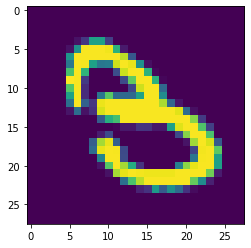

label: 4 pred: 9


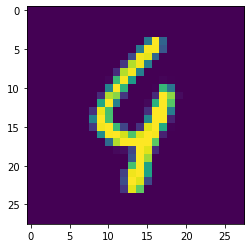

label: 9 pred: 4


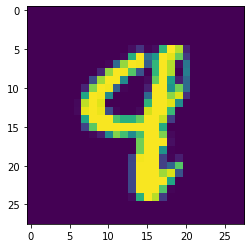

In [103]:
for i in range(3):
    print(f'label: {int(y_mismatch[i])} pred: {int(y_pred_mismatch[i])}')
    plt.imshow(X_mismatch[i].numpy().transpose(1, 2, 0)[:, :, 0])
    plt.show()

# Data Augmentation

Idea: Recognizing objects in an image shouldn't depend on various transformations to the image like rotating, flipping, cropping, scaling, warping, etc. Use these transformations on your training data to artificially increase the size of your training data, and hence improve model performance.

Test Time Augmentation: At test time, for a given test image, use data augmentation on it a few times, make predictions on each augmented image, and average the results together as your true prediction. Can improve test time performance. Used more often in competitions than in production.

Ensembling: Train multiple models on your data, average their predictions at test time, and use that average as your prediction. Due to computational and development costs, this is mostly used in competitions, rarely in production.

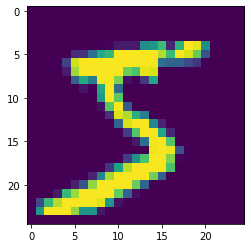

In [130]:
out = torchvision.transforms.RandomCrop(25)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

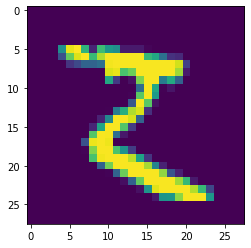

In [132]:
out = torchvision.transforms.RandomHorizontalFlip(p=0.9)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

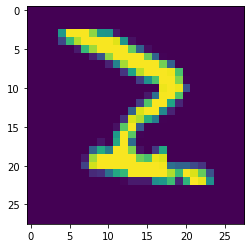

In [133]:
out = torchvision.transforms.RandomVerticalFlip(p=0.9)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

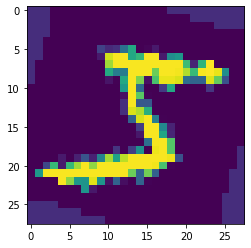

In [138]:
out = torchvision.transforms.RandomRotation(20)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

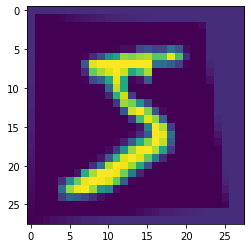

In [141]:
out = torchvision.transforms.RandomPerspective()(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

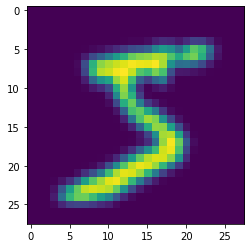

In [148]:
out = torchvision.transforms.GaussianBlur(3)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

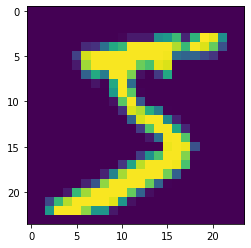

In [151]:
out = torchvision.transforms.CenterCrop(24)(X_train[0])
plt.imshow(out.numpy().transpose(1, 2, 0)[:, :, 0])

In [166]:
transforms = [
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomCrop(26),
    torchvision.transforms.Resize(28)
]

train_data, test_data = get_mnist_data(path='~/data', as_rgb=True, download=False, transforms=transforms)
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: /home/paperspace/data
     Split: Train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
                RandomCrop(size=(26, 26), padding=None)
                Resize(size=28, interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Lambda()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /home/paperspace/data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Lambda()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [167]:
model = torchvision.models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
for layer in [model.layer3, model.layer4]:
    for param in layer.parameters():
        param.requires_grad = True

last_layer = model.fc
in_features = last_layer.in_features
out_features = len(test_data.targets.unique())
model.fc = nn.Linear(in_features, out_features)

model = model.to(device)

  0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1     train loss: 0.1529   train acc: 0.9552   test loss: 0.0915   test acc: 0.9743
epoch: 2     train loss: 0.0758   train acc: 0.9775   test loss: 0.0906   test acc: 0.9708
epoch: 3     train loss: 0.0611   train acc: 0.981    test loss: 0.0966   test acc: 0.972 
epoch: 4     train loss: 0.0549   train acc: 0.9836   test loss: 0.0579   test acc: 0.9824
epoch: 5     train loss: 0.0504   train acc: 0.9847   test loss: 0.0563   test acc: 0.9819
epoch: 6     train loss: 0.0477   train acc: 0.9859   test loss: 0.0722   test acc: 0.9764
epoch: 7     train loss: 0.0408   train acc: 0.9878   test loss: 0.0719   test acc: 0.9804
epoch: 8     train loss: 0.0395   train acc: 0.9878   test loss: 0.0662   test acc: 0.9804
epoch: 9     train loss: 0.0371   train acc: 0.9887   test loss: 0.0367   test acc: 0.988 
epoch: 10    train loss: 0.0336   train acc: 0.9898   test loss: 0.0408   test acc: 0.9872
epoch: 11    train loss: 0.0322   train acc: 0.9901   test loss: 0.0517   test acc: 0.9838

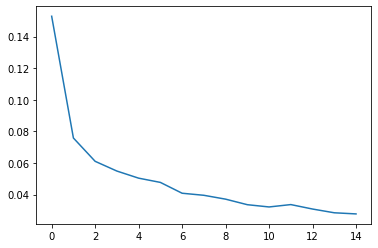

In [168]:
loss_fn = nn.CrossEntropyLoss()
opt = get_optimizer(model, optimizer='adam', lr=0.001, weight_decay=0.)
model = train_model(train_data, model, opt, loss_fn, test_data=test_data, num_epochs=15, batch_size=128)